##### 最终取值是取对数

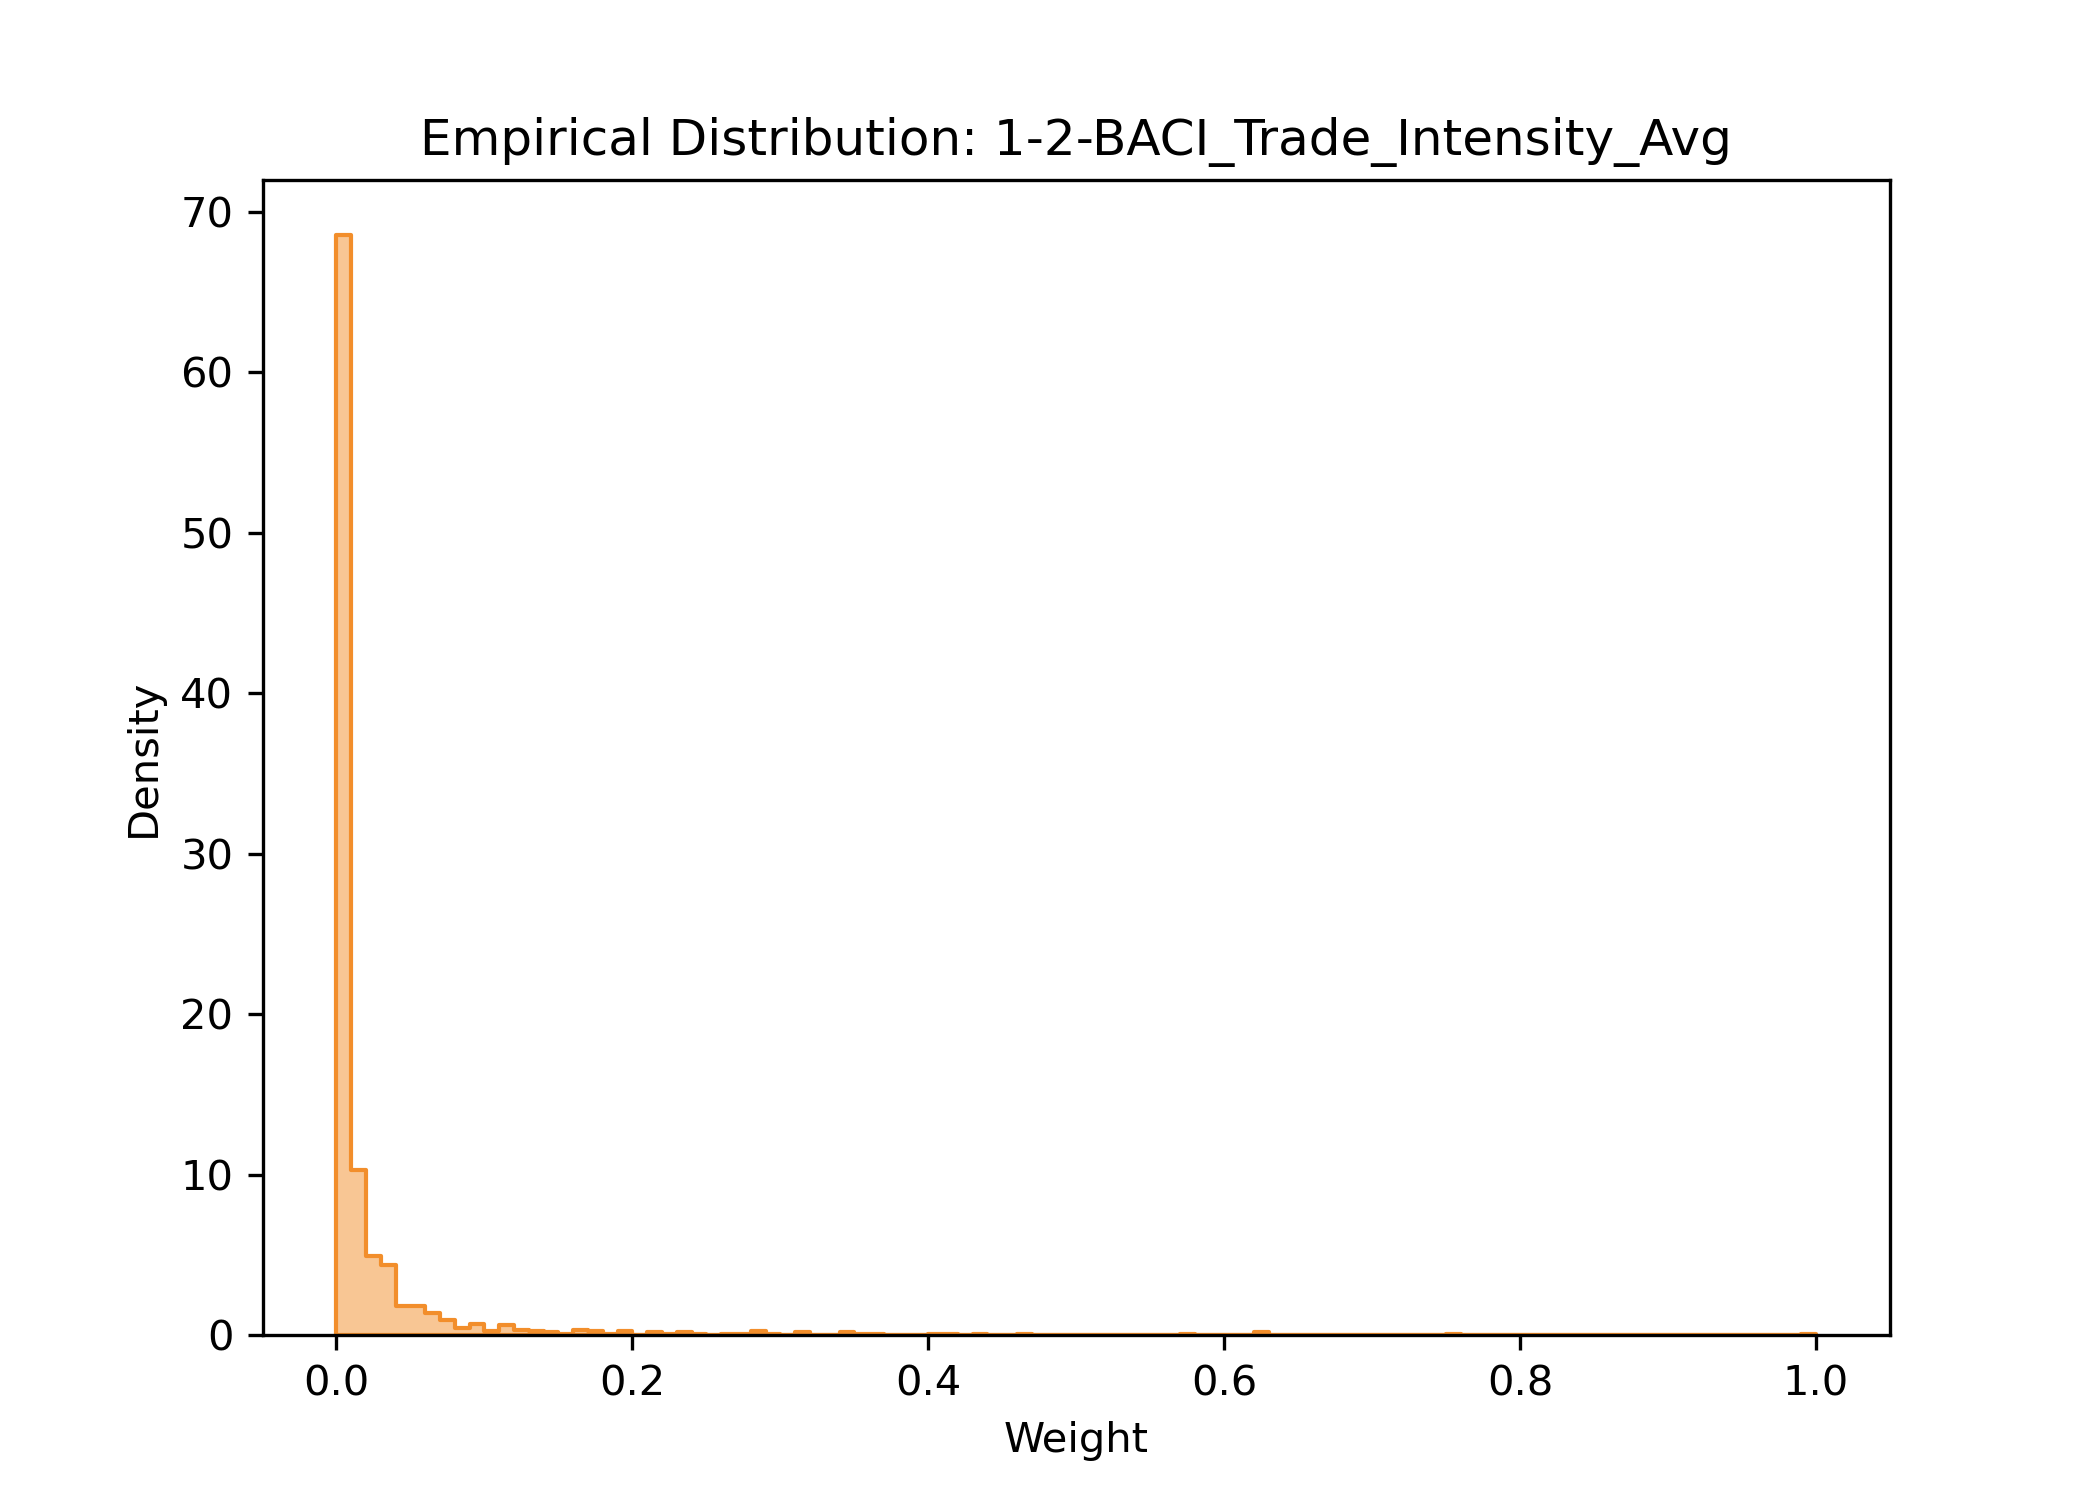

In [1]:
import pandas as pd
import numpy as np
import json
import os

# Relative paths configuration
BACI_DIR = "../../data_origin/BACI/BACI_HS02_V202601"
JSON_PATH = "../country_list.json"
OUT_FILE = "../../data/1-2-BACI_Trade_Intensity_Avg.csv"
YEARS = range(2005, 2024)

def get_average_trade_matrix(dir_path: str, meta_path: str, years: range) -> pd.DataFrame:
    """
    Computes yearly normalized trade matrices and returns the multi-year average.
    :param dir_path: Directory containing BACI HS02 CSV files.
    :param meta_path: Path to the 49-country list JSON.
    :param years: Range of years (2005-2023).
    :return: 49x49 normalized average trade intensity matrix.
    """
    with open(meta_path, 'r', encoding='utf-8') as f:
        countries = json.load(f)['countries']
        mapping = {c['BACI_code']: c['iso'] for c in countries}
    
    target_ids = list(mapping.keys())
    norm_matrices = []

    for yr in years:
        f_path = os.path.join(dir_path, f"BACI_HS02_Y{yr}_V202601.csv")
        if not os.path.exists(f_path): continue
        
        # Load and filter for the 49-country subset
        df = pd.read_csv(f_path, usecols=['i', 'j', 'v'])
        df = df[df['i'].isin(target_ids) & df['j'].isin(target_ids)]
        
        # Aggregate products and symmetrize (Undirected flow: A+B)
        m = df.groupby(['i', 'j'])['v'].sum().unstack(fill_value=0)
        m = m.reindex(index=target_ids, columns=target_ids, fill_value=0)
        m = m + m.T
        
        # Log transformation (Natural Log)
        # Note: np.log is used because user guarantees no zero values.
        m_log = np.log1p(m)
        
        # Annual Local Normalization [0, 1] within 49 countries
        mask = ~np.eye(len(target_ids), dtype=bool)
        v_min, v_max = m_log.values[mask].min(), m_log.values[mask].max()
        m_norm = (m_log - v_min) / (v_max - v_min)
        np.fill_diagonal(m_norm.values, 0)
        
        norm_matrices.append(m_norm)

    # Calculate average across all years and map indices to ISO
    avg_m = (sum(norm_matrices) / len(norm_matrices)).rename(index=mapping, columns=mapping)
    return avg_m.sort_index(axis=0).sort_index(axis=1)

if __name__ == "__main__":
    os.makedirs(os.path.dirname(OUT_FILE), exist_ok=True)
    final_res = get_average_trade_matrix(BACI_DIR, JSON_PATH, YEARS)
    final_res.to_csv(OUT_FILE)

##### 不取对数（弃用版）

In [2]:
import pandas as pd
import numpy as np
import json
import os

# Relative paths configuration
BACI_DIR = "../../data_origin/BACI/BACI_HS02_V202601"
JSON_PATH = "../country_list.json"
OUT_FILE = "../../data/1-2-BACI_Trade_Intensity_Avg.csv"
YEARS = range(2005, 2024)

def get_average_trade_matrix(dir_path: str, meta_path: str, years: range) -> pd.DataFrame:
    """
    Computes yearly normalized trade matrices and returns the multi-year average.
    :param dir_path: Directory containing BACI HS02 CSV files.
    :param meta_path: Path to the 49-country list JSON.
    :param years: Range of years (2005-2023).
    :return: 49x49 normalized average trade intensity matrix.
    """
    with open(meta_path, 'r', encoding='utf-8') as f:
        countries = json.load(f)['countries']
        mapping = {c['BACI_code']: c['iso'] for c in countries}
    
    target_ids = list(mapping.keys())
    norm_matrices = []

    for yr in years:
        f_path = os.path.join(dir_path, f"BACI_HS02_Y{yr}_V202601.csv")
        if not os.path.exists(f_path): continue
        
        # Load and filter for the 49-country subset
        df = pd.read_csv(f_path, usecols=['i', 'j', 'v'])
        df = df[df['i'].isin(target_ids) & df['j'].isin(target_ids)]
        
        # Aggregate products and symmetrize (Undirected flow: A+B)
        m = df.groupby(['i', 'j'])['v'].sum().unstack(fill_value=0)
        m = m.reindex(index=target_ids, columns=target_ids, fill_value=0)
        m = m + m.T
        
        # Log transformation (Natural Log)
        # Note: np.log is used because user guarantees no zero values.
        # === 修改处：去掉 np.log1p ===
        m_log = m
        
        # Annual Local Normalization [0, 1] within 49 countries
        mask = ~np.eye(len(target_ids), dtype=bool)
        v_min, v_max = m_log.values[mask].min(), m_log.values[mask].max()
        m_norm = (m_log - v_min) / (v_max - v_min)
        np.fill_diagonal(m_norm.values, 0)
        
        norm_matrices.append(m_norm)

    # Calculate average across all years and map indices to ISO
    avg_m = (sum(norm_matrices) / len(norm_matrices)).rename(index=mapping, columns=mapping)
    return avg_m.sort_index(axis=0).sort_index(axis=1)

if __name__ == "__main__":
    os.makedirs(os.path.dirname(OUT_FILE), exist_ok=True)
    final_res = get_average_trade_matrix(BACI_DIR, JSON_PATH, YEARS)
    final_res.to_csv(OUT_FILE)